In [ ]:
import os
import time
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# paths dos ONNX
det_path = os.path.abspath("resources/DB_TD500_resnet50.onnx")
rec_path = os.path.abspath("resources/crnn_cs.onnx")

# carrega os modelos
textDetector   = cv2.dnn_TextDetectionModel_DB(det_path)
textRecognizer = cv2.dnn_TextRecognitionModel(rec_path)

textRecognizer.setDecodeType("CTC-greedy")  
# textRecognizer.setDecodeType("CTC-prefix-beam-search")

alphabet = "0123456789abcdefghijklmnopqrstuvwxyz"
textRecognizer.setVocabulary(list(alphabet))  

rec_scale     = 1.0/127.5
rec_input_sz  = (100, 32)
rec_mean      = (127.5, 127.5, 127.5)
textRecognizer.setInputParams(rec_scale, rec_input_sz, rec_mean)

# configurações fixas
bin_thresh   = 0.3
poly_thresh  = 0.5
unclip_ratio = 2.0
max_cands    = 200
scale        = 1.0 / 255.0
mean_vals    = (122.67891434, 116.66876762, 104.00698793)

In [ ]:
def fourPointsTransform(frame, vertices):
    vertices = np.asarray(vertices, dtype=np.float32)
    outputSize = (100, 32)
    target = np.array([
        [0, outputSize[1]-1],
        [0, 0],
        [outputSize[0]-1, 0],
        [outputSize[0]-1, outputSize[1]-1]
    ], dtype=np.float32)
    M = cv2.getPerspectiveTransform(vertices, target)
    return cv2.warpPerspective(frame, M, outputSize)

In [ ]:
def db_crnn_timings(folder, input_size, iterations=5):
    # reaplica setInputParams para cada input_size
    textDetector.setBinaryThreshold(bin_thresh) \
                .setPolygonThreshold(poly_thresh) \
                .setUnclipRatio(unclip_ratio) \
                .setMaxCandidates(max_cands) \
                .setInputParams(scale, (input_size, input_size), mean_vals)
    paths = glob.glob(os.path.join(folder, '*'))
    times = []
    for p in paths:
        img = cv2.imread(p)
        if img is None: continue
        for _ in range(iterations):
            im = cv2.resize(img, (input_size, input_size))
            t0 = time.time()
            boxes, _ = textDetector.detect(im)
            for box in boxes:
                roi = fourPointsTransform(im, box)
                _ = textRecognizer.recognize(roi)
            times.append(time.time() - t0)
    return np.array(times)


In [32]:


folder = r"AC\AC5\images"
sizes = [64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024]


  64px → mean 0.051s, std 0.016s
 128px → mean 0.037s, std 0.009s
 192px → mean 0.066s, std 0.011s
 256px → mean 0.171s, std 0.065s
 320px → mean 0.124s, std 0.021s
 384px → mean 0.163s, std 0.016s
 448px → mean 0.235s, std 0.019s
 512px → mean 0.324s, std 0.031s
 576px → mean 0.448s, std 0.054s
 640px → mean 0.547s, std 0.078s
 704px → mean 0.661s, std 0.112s
 768px → mean 0.817s, std 0.116s
 832px → mean 1.021s, std 0.125s
 896px → mean 1.157s, std 0.156s
 960px → mean 1.393s, std 0.110s
1024px → mean 1.461s, std 0.067s


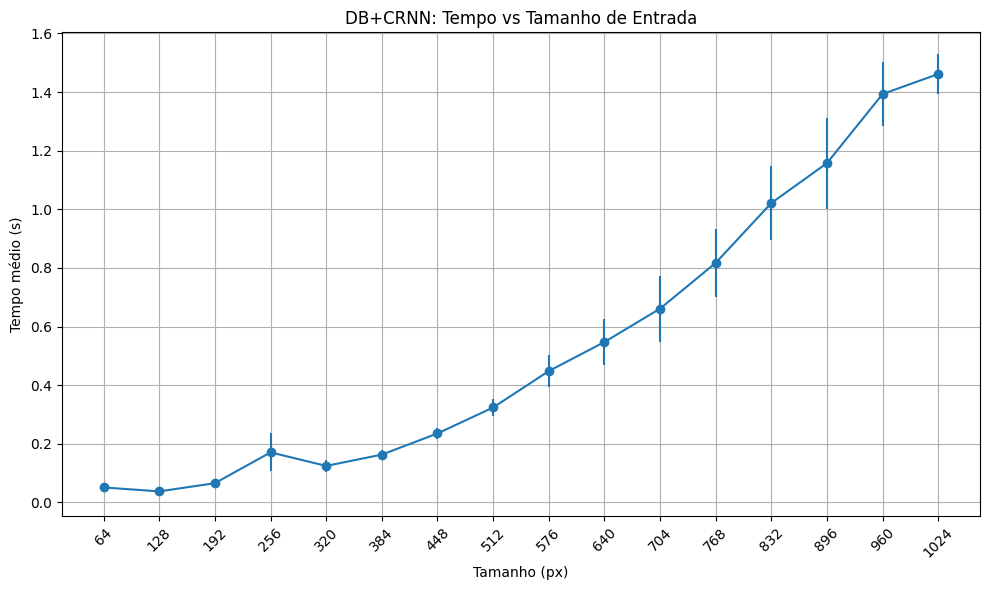

In [ ]:

results = {}
for s in sizes:
    ts = db_crnn_timings(folder, s, iterations=10)
    results[s] = (ts.mean(), ts.std())
    print(f"{s:4d}px → mean {results[s][0]:.3f}s, std {results[s][1]:.3f}s")

x = sizes
y = [results[s][0] for s in x]
yerr = [results[s][1] for s in x]

plt.figure(figsize=(10,6))
plt.errorbar(x, y, yerr=yerr, marker='o', linestyle='-')
plt.title('DB+CRNN: Tempo vs Tamanho de Entrada')
plt.xlabel('Tamanho (px)')
plt.ylabel('Tempo médio (s)')
plt.xticks(x, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




Podemos ver que o tempo de execução cresce quase exponencialmente com o aumento da resolução. Acima de 512px, o custo em tempo cresce rapidamente, com ganhos marginais em desempenho OCR. Recomenda-se usar 320–512px como melhor trade-off entre velocidade e qualidade.